<h1><center>EE460J: Data Science Lab — Fall 2021</center></h1>
<h3><center>Predicting NBA MVP Using Regular Season Data </center></h3> <br>
Ethan Blumenfeld / ejb2768 <br>
Nafeezur Chowdhury / nrc865<br>
Kenan Hurd / kah4285<br>
Nikolai Kumar / nak826<br>
Trajan Schmidt / tms3893<br>
Renzo Teruya / rt25884<br>


In [ ]:
#Import data/datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
#from nba_api.stats.static import players
#from nba_api.stats import endpoints
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import norm
from operator import itemgetter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


### Dataset that can be useful for historical data (didnt dive deep enough into nba_api to find how to easily get seasonal stats for each player easily)
Only has the stats of the top 10 in mvp voting in each season 
from 1979-80 season to 2017-18 season

https://github.com/dribbleanalytics/ml-mvp-predict/blob/master/2018-19-season/mid-season/final-csv-data/historical-mvps.csv

additional features to consider:
1.   How many MVPs won previously (Voter Fatigue)
2.   How many consecutive MVPs have been won (like the year prior or both years prior)
3. From what I've heard MVP is largely a press award so frequency players are talked about in the news
4. ???




In [ ]:
historical_df = pd.read_csv('https://raw.githubusercontent.com/dribbleanalytics/ml-mvp-predict/master/2019-20-season/final-csv-data/historical-data.csv')

# Adding More Recent MVPs


In [ ]:
historical_df

,rank,won_mvp,player,season_start,age,pos,pos_number,tm,pts_won,pts_max,vote_share,all_star_votes,g,team_wins,overall_seed,preseason_odds_rank,mp,fgm,fga,fg_perc,3pm,3pa,3p_perc,2pm,2pa,2p_perc,efg,ftm,fta,ft_perc,orb,drb,trb,ast,stl,blk,tov,pf,pts,per,ts,3par,ftr,orb_perc,drb_perc,trb_perc,ast_perc,stl_perc,blk_perc,tov_perv,usg_perc,ws,ws_per_48,vorp,bpm,offensive_raptor,defensive_raptor
0,1,1,Larry Bird,1984,28,SF,3,BOS,763.0,780,0.978,564521,80.0,63.0,1,1.5,39.5,11.5,22.0,0.522,0.7,1.6,0.427,10.8,20.4,0.529,0.538,5.0,5.7,0.882,2.1,8.5,10.5,6.6,1.6,1.2,3.1,2.6,28.7,26.5,0.585,0.074,0.260,6.0,22.6,14.7,25.7,1.9,1.7,11.2,28.5,15.7,0.238,8.4,8.5,5.419678,1.909035
1,2,0,Magic Johnson,1984,25,PG,1,LAL,264.0,780,0.338,957447,77.0,62.0,2,1.5,36.1,6.5,11.7,0.561,0.1,0.5,0.189,6.5,11.2,0.577,0.565,5.1,6.0,0.843,1.2,5.0,6.2,12.6,1.5,0.3,4.0,2.0,18.3,23.2,0.637,0.041,0.516,4.1,14.4,9.7,42.5,1.9,0.5,21.7,20.5,12.7,0.220,5.2,5.4,6.885959,0.047804
2,3,0,Moses Malone,1984,29,C,5,PHI,218.0,780,0.279,662445,79.0,58.0,4,3.0,37.4,7.6,16.3,0.469,0.0,0.0,0.000,7.6,16.2,0.470,0.469,9.3,11.4,0.815,4.9,8.2,13.1,1.6,0.8,1.6,3.6,2.7,24.6,22.5,0.577,0.002,0.704,14.8,24.4,19.7,6.6,1.1,2.4,14.5,26.8,11.9,0.193,2.6,1.5,1.585412,1.104897
3,4,0,Kareem Abdul-Jabbar,1984,37,C,5,LAL,206.0,780,0.264,554402,79.0,62.0,2,1.5,33.3,9.2,15.3,0.599,0.0,0.0,0.000,9.2,15.3,0.600,0.599,3.7,5.0,0.732,2.1,5.8,7.9,3.2,0.8,2.1,2.5,3.0,22.0,22.9,0.628,0.001,0.327,7.7,18.2,13.5,13.1,1.1,3.3,12.5,24.3,11.2,0.204,4.6,4.9,2.516025,1.845929
4,5,0,Terry Cummings,1984,23,PF,4,MIL,138.0,780,0.177,0,79.0,59.0,3,6.5,34.5,9.6,19.4,0.495,0.0,0.0,0.000,9.6,19.4,0.496,0.495,4.3,5.9,0.741,3.1,6.0,9.1,2.9,1.5,0.8,2.4,3.3,23.6,22.1,0.536,0.001,0.302,10.0,19.1,14.6,13.5,2.1,1.5,9.9,28.8,10.7,0.189,4.0,3.8,2.236314,1.818561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,6,0,Damian Lillard,2018,28,PG,1,POR,69.0,1010,0.068,1043785,80.0,53.0,6,16.0,35.5,8.5,19.2,0.444,3.0,8.0,0.369,5.6,11.1,0.499,0.522,5.9,6.4,0.912,0.9,3.8,4.6,6.9,1.1,0.4,2.7,1.9,25.8,23.7,0.588,0.419,0.335,2.6,11.1,7.0,30.6,1.5,1.0,10.8,29.3,12.1,0.205,5.4,5.5,6.364833,-0.762903
345,7,0,Joel Embiid,2018,24,C,5,PHI,49.0,1010,0.049,2783833,64.0,51.0,7,6.0,33.7,9.1,18.7,0.484,1.2,4.1,0.300,7.8,14.6,0.535,0.517,8.2,10.1,0.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5,26.1,0.593,0.219,0.541,8.1,34.0,21.4,18.4,1.0,4.4,13.2,33.3,8.7,0.194,3.3,4.1,2.686679,4.840821
346,8,0,Kevin Durant,2018,30,SF,3,GSW,25.0,1010,0.025,3150648,78.0,57.0,3,1.0,34.6,9.2,17.7,0.521,1.8,5.0,0.353,7.5,12.8,0.587,0.571,5.7,6.5,0.885,0.4,5.9,6.4,5.9,0.7,1.1,2.9,2.0,26.0,24.2,0.631,0.281,0.366,1.4,17.5,9.8,26.2,1.0,2.6,12.3,29.0,11.5,0.204,4.3,4.3,5.220352,-0.156450
347,9,0,Kawhi Leonard,2018,27,SF,3,TOR,13.0,1010,0.013,3580531,60.0,58.0,2,5.0,34.0,9.3,18.8,0.496,1.9,5.0,0.371,7.5,13.8,0.542,0.546,6.1,7.1,0.854,1.3,6.0,7.3,3.3,1.8,0.4,2.0,1.5,26.6,25.8,0.606,0.267,0.377,4.2,18.6,11.6,16.4,2.5,1.0,8.4,30.3,9.5,0.224,3.6,5.0,5.729369,0.899991


In [ ]:
player_mvps = {}
player_listed = {}
previous_player = ['', 0]
num_won_mvps = []
num_listed_mvps = []
consecutive_mvps = []


for index, row in historical_df[:].iterrows():
  if row['player'] in player_listed.keys():
    player_listed[row['player']] += 1
    if row['player'] == previous_player[0]:
      consecutive_mvps.append(previous_player[1])
    else:
      consecutive_mvps.append(0)
    if row['won_mvp'] == 1:
      player_mvps[row['player']] += 1
      if previous_player[0] == row['player']:
        previous_player[1] += 1
      else:
        previous_player = [row['player'], 1]
  else:
    player_listed[row['player']] = 1
    player_mvps[row['player']] = 0
    consecutive_mvps.append(0)
    if row['won_mvp'] == 1:
      player_mvps[row['player']] += 1
      previous_player = [row['player'], 1]
    
  num_won_mvps.append(player_mvps[row['player']])
  num_listed_mvps.append(player_listed[row['player']])

consec = []
for i in range(0,349):
    consec.append(0)
consec[10] = 1
consec[22] = 2
consec[32] = 1
consec[41] = 1
consec[50] = 1
consec[62] = 2
consec[71] = 1
consec[83] = 2
consec[99] = 1
consec[104] = 1
consec[111] = 1
consec[121] = 1
consec[131] = 1
consec[153] = 1
consec[162] = 1
consec[178] = 1
consec[180] = 1
consec[191] = 2
consec[209] = 1
consec[219] = 2
consec[239] = 1
consec[248] = 1
consec[260] = 2
consec[279] = 1
consec[290] = 2
consec[308] = 1
consec[323] = 2
consec[332] = 1
consec[340] = 1

In [ ]:
X = historical_df.copy()
X['num_mvps_won'] = num_won_mvps
X['num_top_rank'] = num_listed_mvps
X['consecutive_mvps'] = consec

X = X.drop(['rank', 'season_start', 'age', 'player', 'pos', 'pos_number', 'tm', 'pts_won', 'pts_max', 'all_star_votes', 'preseason_odds_rank', 'won_mvp'], axis=1)
Y = X['vote_share']

In [ ]:
X[:33]

,vote_share,g,team_wins,overall_seed,mp,fgm,fga,fg_perc,3pm,3pa,3p_perc,2pm,2pa,2p_perc,efg,ftm,fta,ft_perc,orb,drb,trb,ast,stl,blk,tov,pf,pts,per,ts,3par,ftr,orb_perc,drb_perc,trb_perc,ast_perc,stl_perc,blk_perc,tov_perv,usg_perc,ws,ws_per_48,vorp,bpm,offensive_raptor,defensive_raptor,num_mvps_won,num_top_rank,consecutive_mvps
0,0.978,80.0,63.0,1,39.5,11.5,22.0,0.522,0.7,1.6,0.427,10.8,20.4,0.529,0.538,5.0,5.7,0.882,2.1,8.5,10.5,6.6,1.6,1.2,3.1,2.6,28.7,26.5,0.585,0.074,0.260,6.0,22.6,14.7,25.7,1.9,1.7,11.2,28.5,15.7,0.238,8.4,8.5,5.419678,1.909035,1,1,0
1,0.338,77.0,62.0,2,36.1,6.5,11.7,0.561,0.1,0.5,0.189,6.5,11.2,0.577,0.565,5.1,6.0,0.843,1.2,5.0,6.2,12.6,1.5,0.3,4.0,2.0,18.3,23.2,0.637,0.041,0.516,4.1,14.4,9.7,42.5,1.9,0.5,21.7,20.5,12.7,0.220,5.2,5.4,6.885959,0.047804,0,1,0
2,0.279,79.0,58.0,4,37.4,7.6,16.3,0.469,0.0,0.0,0.000,7.6,16.2,0.470,0.469,9.3,11.4,0.815,4.9,8.2,13.1,1.6,0.8,1.6,3.6,2.7,24.6,22.5,0.577,0.002,0.704,14.8,24.4,19.7,6.6,1.1,2.4,14.5,26.8,11.9,0.193,2.6,1.5,1.585412,1.104897,0,1,0
3,0.264,79.0,62.0,2,33.3,9.2,15.3,0.599,0.0,0.0,0.000,9.2,15.3,0.600,0.599,3.7,5.0,0.732,2.1,5.8,7.9,3.2,0.8,2.1,2.5,3.0,22.0,22.9,0.628,0.001,0.327,7.7,18.2,13.5,13.1,1.1,3.3,12.5,24.3,11.2,0.204,4.6,4.9,2.516025,1.845929,0,1,0
4,0.177,79.0,59.0,3,34.5,9.6,19.4,0.495,0.0,0.0,0.000,9.6,19.4,0.496,0.495,4.3,5.9,0.741,3.1,6.0,9.1,2.9,1.5,0.8,2.4,3.3,23.6,22.1,0.536,0.001,0.302,10.0,19.1,14.6,13.5,2.1,1.5,9.9,28.8,10.7,0.189,4.0,3.8,2.236314,1.818561,0,1,0
5,0.172,82.0,38.0,14,38.3,10.2,19.8,0.515,0.1,0.6,0.173,10.1,19.2,0.526,0.518,7.7,9.1,0.845,2.0,4.5,6.5,5.9,2.4,0.8,3.5,3.5,28.2,25.8,0.592,0.032,0.459,6.3,13.2,9.8,25.3,3.0,1.3,13.0,29.8,14.0,0.213,8.1,8.2,5.948410,1.565631,0,1,0
6,0.090,55.0,24.0,21,37.5,12.6,23.7,0.530,0.0,0.2,0.100,12.5,23.5,0.534,0.531,7.7,10.0,0.772,2.1,3.7,5.8,3.7,1.3,0.3,3.7,3.5,32.9,25.2,0.585,0.008,0.424,6.2,11.8,8.9,18.6,1.7,0.4,11.7,35.1,7.1,0.166,3.3,4.3,3.778192,-0.885242,0,1,0
7,0.083,73.0,59.0,3,37.5,7.7,15.9,0.483,0.1,0.5,0.273,7.6,15.5,0.489,0.487,6.2,7.5,0.828,2.0,3.3,5.4,5.2,1.6,0.5,2.5,2.7,21.7,20.1,0.565,0.028,0.472,6.1,9.8,7.9,20.1,2.1,0.8,11.6,23.6,11.2,0.197,4.6,4.7,3.706650,0.815539,0,1,0
8,0.081,81.0,46.0,7,38.1,8.0,17.4,0.458,0.4,1.4,0.257,7.6,16.0,0.476,0.468,4.9,6.1,0.809,1.4,3.0,4.5,13.9,2.3,0.3,3.7,3.6,21.2,22.2,0.529,0.080,0.350,3.7,8.7,6.1,47.9,2.8,0.4,15.7,24.0,11.2,0.173,5.6,5.2,6.312434,0.854290,0,1,0
9,0.033,82.0,48.0,6,37.6,9.2,18.3,0.502,0.0,0.1,0.000,9.2,18.2,0.504,0.502,3.7,5.5,0.676,2.8,7.6,10.4,2.7,1.0,2.0,4.0,3.7,22.1,17.4,0.533,0.004,0.299,8.2,22.6,15.4,10.4,1.2,3.1,16.1,25.9,6.2,0.096,2.1,0.8,-1.480698,0.781033,0,1,0


In [ ]:
train, test = train_test_split(X, test_size=.2, random_state=42)

xtrain = train.copy();
ytrain = train['vote_share']
xtrain = xtrain.drop('vote_share', axis=1)

xtest = test.copy()
ytest = test['vote_share']
xtest = xtest.drop('vote_share', axis=1)


In [ ]:
model = RandomForestRegressor(random_state=42, n_estimators=100, criterion='squared_error')
y = []

model.fit(xtrain, ytrain.values.ravel())
y_pred = model.predict(xtest)
print("Mean squared error: %.3f" % mean_squared_error(ytest, y_pred))
print('R2 score: %.3f' % r2_score(ytest, y_pred))
cvScore = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'r2')
print("R2 cross validation score: %0.2f (+/- %0.2f)" % (cvScore.mean(), cvScore.std() * 2))
for i in y_pred:
    y.append(i)

Mean squared error: 0.037
R2 score: 0.377
R2 cross validation score: 0.04 (+/- 0.80)


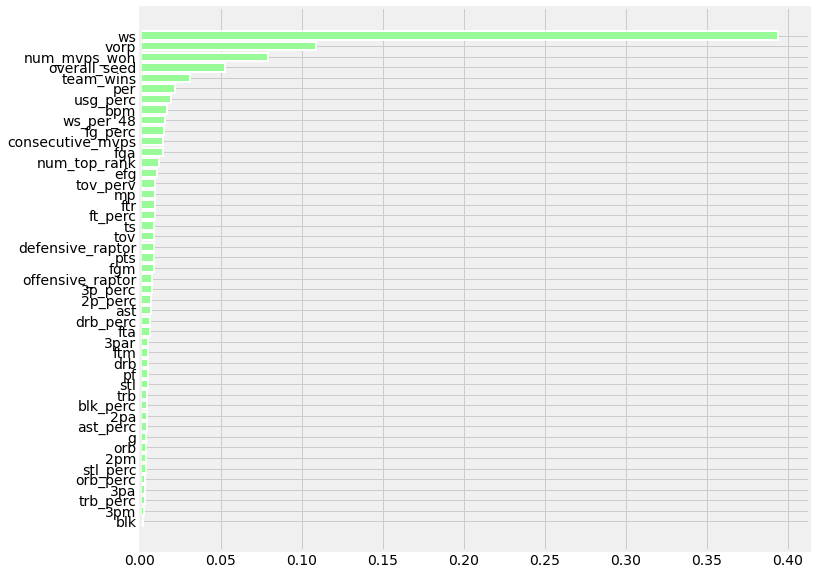

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.style.use('fivethirtyeight')
model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.barh(xtrain.columns[sorted_idx], model.feature_importances_[sorted_idx], color= 'palegreen', edgecolor= 'white', linewidth = 2)
plt.show()

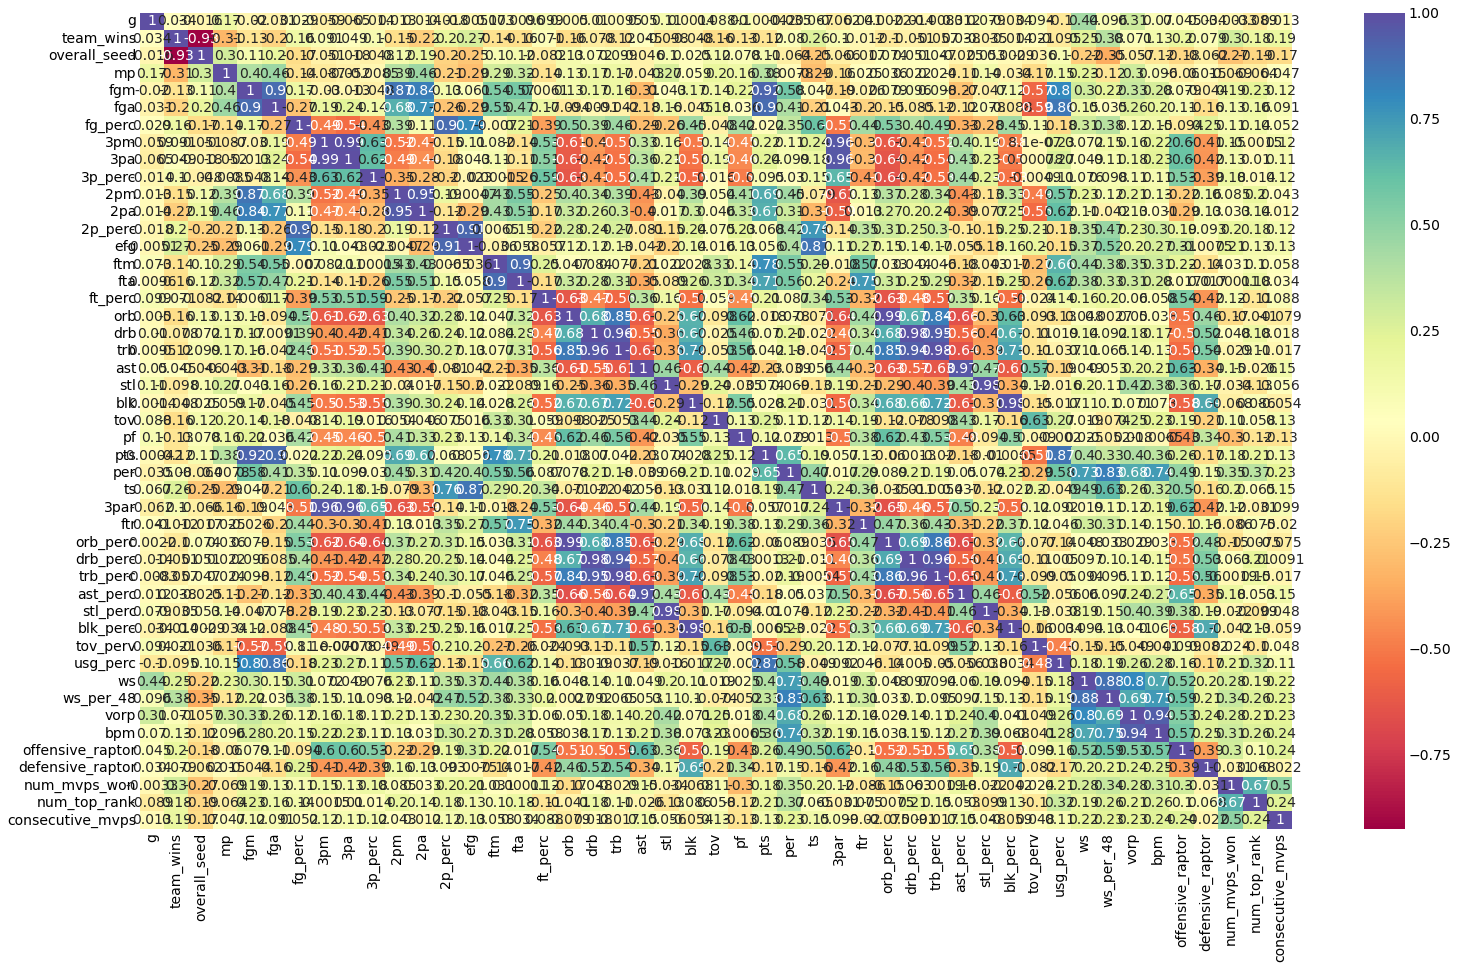

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(23, 14))
fig.set_facecolor('white')

sns.heatmap(X.drop('vote_share', axis=1).corr(), annot=True, cmap="Spectral")

In [ ]:
modelLR = LinearRegression()

modelLR.fit(xtrain, ytrain.values.ravel())
y_pred = modelLR.predict(xtest)
print("Linear Mean squared error: %.3f" % mean_squared_error(ytest, y_pred))
print('R2 score: %.3f' % r2_score(ytest, y_pred))
cvScore = cross_val_score(modelLR, xtest, ytest.values.ravel(), cv = 3, scoring = 'r2')
print("R2 cross validation score: %0.2f (+/- %0.2f)" % (cvScore.mean(), cvScore.std() * 2))

Linear Mean squared error: 0.032
R2 score: 0.460
R2 cross validation score: -6065.50 (+/- 16812.98)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Optimal number of features: 45
Selected features: ['g', 'team_wins', 'overall_seed', 'fgm', 'fga', 'fg_perc', '3pm', '3pa', '3p_perc', '2pm', '2pa', '2p_perc', 'efg', 'ftm', 'fta', 'ft_perc', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'per', 'ts', '3par', 'ftr', 'orb_perc', 'drb_perc', 'trb_perc', 'ast_perc', 'stl_perc', 'blk_perc', 'usg_perc', 'ws', 'ws_per_48', 'vorp', 'bpm', 'offensive_raptor', 'defensive_raptor', 'num_mvps_won', 'num_top_rank', 'consecutive_mvps']


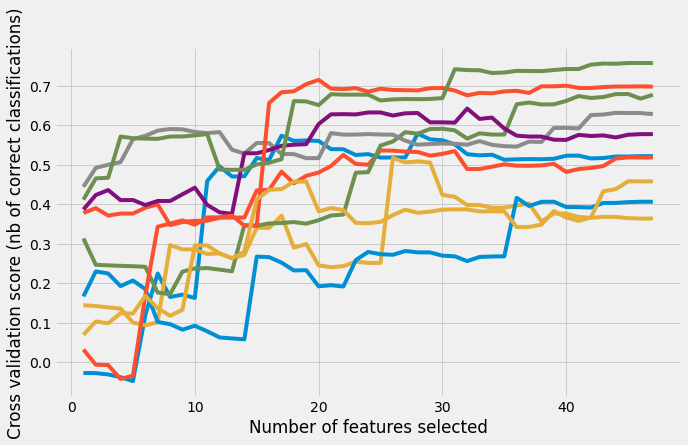

In [ ]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=modelLR, step=1, cv=10, scoring='r2')
rfecv.fit(xtrain, ytrain)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(xtrain.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfe = RFE(estimator=modelLR, n_features_to_select=23)
rfe = rfe.fit(xtrain, ytrain)
print('Selected features: %s' % list(xtrain.columns[rfe.support_]))

Selected features: ['fgm', 'fga', 'fg_perc', '3pm', '3pa', '3p_perc', '2pm', '2pa', '2p_perc', 'efg', 'ftm', 'fta', 'ft_perc', 'stl', 'tov', 'pts', 'ts', '3par', 'ws_per_48', 'vorp', 'bpm', 'num_mvps_won', 'consecutive_mvps']


In [ ]:
Selected_features = ['overall_seed', 'fgm', 'fga', 'fg_perc', '3pm', '3pa', '3p_perc', '2pm', '2pa', '2p_perc', 'efg', 'ftm', 'fta', 'ft_perc', 'orb', 'drb', 'trb', 'stl', 'tov', 'pf', 'pts', 'ts', '3par', 'ftr', 'stl_perc', 'tov_perv', 'ws', 'ws_per_48']
x_28 = xtrain[Selected_features]
modelLR.fit(x_28, ytrain.values.ravel())

xtest_28 = xtest[Selected_features]
y_pred = modelLR.predict(xtest_28)
print("Mean squared error: %.3f" % mean_squared_error(ytest, y_pred))
print('R2 score: %.3f' % r2_score(ytest, y_pred))
cvScore = cross_val_score(modelLR, xtest_28, ytest.values.ravel(), cv = 3, scoring = 'r2')
print("R2 cross validation score: %0.2f (+/- %0.2f)" % (cvScore.mean(), cvScore.std() * 2))

Mean squared error: 0.031
R2 score: 0.481
R2 cross validation score: -3.31 (+/- 7.65)


In [ ]:
X3 = X[['overall_seed', 'mp', 'fg_perc', 'efg', 'tov', 'pts', 'per', 'ts', 'usg_perc', 'ws_per_48', 'vorp', 'bpm', 'offensive_raptor', 'defensive_raptor', 'num_mvps_won', 'num_top_rank', 'consecutive_mvps']].copy()
knn = neighbors.KNeighborsRegressor(algorithm='ball_tree', metric='euclidean', n_neighbors=8, weights='distance')
knn.fit(X3,Y)

KNeighborsRegressor(algorithm='ball_tree', metric='euclidean', n_neighbors=8,
                    weights='distance')

In [ ]:
copy = X.copy()
copy['season_start'] = historical_df['season_start']
copy['player'] = historical_df['player']
y1984 = copy[copy['season_start']==1984]
y1985 = copy[copy['season_start']==1985]
y1986= copy[copy['season_start']==1986]
y1987= copy[copy['season_start']==1987]
y1988= copy[copy['season_start']==1988]
y1989= copy[copy['season_start']==1989]
y1990= copy[copy['season_start']==1990]
y1991= copy[copy['season_start']==1991]
y1992= copy[copy['season_start']==1992]
y1993= copy[copy['season_start']==1993]
y1994= copy[copy['season_start']==1994]
y1995= copy[copy['season_start']==1995]
y1996= copy[copy['season_start']==1996]
y1997= copy[copy['season_start']==1997]
y1998= copy[copy['season_start']==1998]
y1999= copy[copy['season_start']==1999]
y2000=copy[copy['season_start']==2000]
y2001=copy[copy['season_start']==2001]
y2002=copy[copy['season_start']==2002]
y2003=copy[copy['season_start']==2003]
y2004=copy[copy['season_start']==2004]
y2005=copy[copy['season_start']==2005]
y2006=copy[copy['season_start']==2006]
y2007=copy[copy['season_start']==2007]
y2008=copy[copy['season_start']==2008]
y2009=copy[copy['season_start']==2009]
y2010=copy[copy['season_start']==2010]
y2011=copy[copy['season_start']==2011]
y2012=copy[copy['season_start']==2012]
y2013=copy[copy['season_start']==2013]
y2014=copy[copy['season_start']==2014]
y2015=copy[copy['season_start']==2015]
y2016=copy[copy['season_start']==2016]
y2017=copy[copy['season_start']==2017]
y2018=copy[copy['season_start']==2018]

seasons=[y1984,y1985,y1986,y1987,y1988,y1989,y1990,y1991,y1992,y1993,y1994,y1995,y1996,y1997,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,y2017,y2018]

In [ ]:
xLR = y1984[Selected_features]
predic = modelLR.predict(xLR)

prediction84 = pd.DataFrame({"Year": y1984['season_start'],
                      "Player": y1984['player'],
                      "Prediction": predic })
prediction84 = prediction84[prediction84['Prediction'] >= 0]
prediction84 = prediction84.sort_values('Prediction', ascending=False)
prediction84

,Year,Player,Prediction
0,1984,Larry Bird,0.735491
1,1984,Magic Johnson,0.388287
2,1984,Moses Malone,0.335921
4,1984,Terry Cummings,0.275286
3,1984,Kareem Abdul-Jabbar,0.240537
8,1984,Isiah Thomas,0.146228
5,1984,Michael Jordan,0.120472
9,1984,Ralph Sampson,0.062047
7,1984,Sidney Moncrief,0.019050


In [ ]:
xLR = y1985[Selected_features]
predic = modelLR.predict(xLR)

prediction85 = pd.DataFrame({"Year": y1985['season_start'],
                      "Player": y1985['player'],
                      "Prediction": predic })
prediction85 = prediction85[prediction85['Prediction'] >= 0]
prediction85 = prediction85.sort_values('Prediction', ascending=False)
prediction85

,Year,Player,Prediction
10,1985,Larry Bird,0.740697
11,1985,Dominique Wilkins,0.403137
12,1985,Magic Johnson,0.337789
17,1985,Alex English,0.231831
14,1985,Kareem Abdul-Jabbar,0.227236
15,1985,Charles Barkley,0.197532
19,1985,Moses Malone,0.140586
13,1985,Hakeem Olajuwon,0.099376


In [ ]:
xLR = y1986[Selected_features]
predic = modelLR.predict(xLR)

prediction86 = pd.DataFrame({"Year": y1986['season_start'],
                      "Player": y1986['player'],
                      "Prediction": predic })
prediction86 = prediction86[prediction86['Prediction'] >= 0]
prediction86 = prediction86.sort_values('Prediction', ascending=False)
prediction86

,Year,Player,Prediction
20,1986,Magic Johnson,0.653592
22,1986,Larry Bird,0.608960
21,1986,Michael Jordan,0.522223
23,1986,Kevin McHale,0.451907
24,1986,Dominique Wilkins,0.431675
25,1986,Charles Barkley,0.247963
29,1986,Moses Malone,0.072345
26,1986,Hakeem Olajuwon,0.016675


In [ ]:
xLR = y1987[Selected_features]
predic = modelLR.predict(xLR)

prediction87 = pd.DataFrame({"Year": y1987['season_start'],
                      "Player": y1987['player'],
                      "Prediction": predic })
prediction87 = prediction87[prediction87['Prediction'] >= 0]
prediction87 = prediction87.sort_values('Prediction', ascending=False)
prediction87

,Year,Player,Prediction
30,1987,Michael Jordan,0.803771
31,1987,Larry Bird,0.695923
35,1987,Dominique Wilkins,0.291252
34,1987,Clyde Drexler,0.288231
32,1987,Magic Johnson,0.269166
33,1987,Charles Barkley,0.183975
37,1987,Karl Malone,0.153847
38,1987,Fat Lever,0.083083
36,1987,Hakeem Olajuwon,0.029961
39,1987,John Stockton,0.019979


In [ ]:
xLR = y1988[Selected_features]
predic = modelLR.predict(xLR)

prediction88 = pd.DataFrame({"Year": y1988['season_start'],
                      "Player": y1988['player'],
                      "Prediction": predic })
prediction88 = prediction88[prediction88['Prediction'] >= 0]
prediction88 = prediction88.sort_values('Prediction', ascending=False)
prediction88

,Year,Player,Prediction
41,1988,Michael Jordan,0.667864
40,1988,Magic Johnson,0.635210
42,1988,Karl Malone,0.428468
46,1988,John Stockton,0.203557
44,1988,Hakeem Olajuwon,0.181740
49,1988,Mark Price,0.172055
45,1988,Charles Barkley,0.147167
47,1988,Kevin Johnson,0.117993
43,1988,Patrick Ewing,0.095702
48,1988,Tom Chambers,0.003449


In [ ]:
xLR = y1989[Selected_features]
predic = modelLR.predict(xLR)

prediction89 = pd.DataFrame({"Year": y1989['season_start'],
                      "Player": y1989['player'],
                      "Prediction": predic })
prediction89 = prediction89[prediction89['Prediction'] >= 0]
prediction89 = prediction89.sort_values('Prediction', ascending=False)
prediction89

,Year,Player,Prediction
52,1989,Michael Jordan,0.730127
50,1989,Magic Johnson,0.527972
53,1989,Karl Malone,0.524734
55,1989,David Robinson,0.446535
51,1989,Charles Barkley,0.405426
54,1989,Patrick Ewing,0.260119
59,1989,Larry Bird,0.210861
56,1989,Hakeem Olajuwon,0.159186
58,1989,John Stockton,0.156302
57,1989,Tom Chambers,0.035015


In [ ]:
xLR = y1990[Selected_features]
predic = modelLR.predict(xLR)

prediction90 = pd.DataFrame({"Year": y1990['season_start'],
                      "Player": y1990['player'],
                      "Prediction": predic })
prediction90 = prediction90[prediction90['Prediction'] >= 0]
prediction90 = prediction90.sort_values('Prediction', ascending=False)
prediction90

,Year,Player,Prediction
61,1990,Michael Jordan,0.845825
63,1990,David Robinson,0.554830
62,1990,Magic Johnson,0.417040
65,1990,Karl Malone,0.341234
66,1990,Clyde Drexler,0.242564
64,1990,Charles Barkley,0.191302
67,1990,Kevin Johnson,0.152815
69,1990,Larry Bird,0.138137
70,1990,Terry Porter,0.107291
68,1990,Dominique Wilkins,0.067957


In [ ]:
xLR = y1991[Selected_features]
predic = modelLR.predict(xLR)

prediction91 = pd.DataFrame({"Year": y1991['season_start'],
                      "Player": y1991['player'],
                      "Prediction": predic })
prediction91 = prediction91[prediction91['Prediction'] >= 0]
prediction91 = prediction91.sort_values('Prediction', ascending=False)
prediction91

,Year,Player,Prediction
71,1991,Michael Jordan,0.655791
74,1991,Karl Malone,0.410849
72,1991,Clyde Drexler,0.392798
79,1991,Scottie Pippen,0.362998
75,1991,Patrick Ewing,0.214548
73,1991,David Robinson,0.214499
78,1991,Tim Hardaway,0.162010
80,1991,Dennis Rodman,0.124548
76,1991,Chris Mullin,0.116556


In [ ]:
xLR = y1992[Selected_features]
predic = modelLR.predict(xLR)

prediction92 = pd.DataFrame({"Year": y1992['season_start'],
                      "Player": y1992['player'],
                      "Prediction": predic })
prediction92 = prediction92[prediction92['Prediction'] >= 0]
prediction92 = prediction92.sort_values('Prediction', ascending=False)
prediction92

,Year,Player,Prediction
83,1992,Michael Jordan,0.810266
82,1992,Hakeem Olajuwon,0.558787
81,1992,Charles Barkley,0.494601
84,1992,Patrick Ewing,0.337513
88,1992,Karl Malone,0.229906
85,1992,Dominique Wilkins,0.155029
86,1992,David Robinson,0.122732
87,1992,Shaquille O'Neal,0.060439


In [ ]:
xLR = y1993[Selected_features]
predic = modelLR.predict(xLR)

prediction93 = pd.DataFrame({"Year": y1993['season_start'],
                      "Player": y1993['player'],
                      "Prediction": predic })
prediction93 = prediction93[prediction93['Prediction'] >= 0]
prediction93 = prediction93.sort_values('Prediction', ascending=False)
prediction93

,Year,Player,Prediction
91,1993,David Robinson,0.716513
90,1993,Hakeem Olajuwon,0.584785
93,1993,Shaquille O'Neal,0.512982
94,1993,Patrick Ewing,0.469886
92,1993,Scottie Pippen,0.241721
96,1993,Shawn Kemp,0.219112
97,1993,Karl Malone,0.201435
99,1993,Charles Barkley,0.072999
98,1993,Mark Price,0.029786


In [ ]:
xLR = y1994[Selected_features]
predic = modelLR.predict(xLR)

prediction94 = pd.DataFrame({"Year": y1994['season_start'],
                      "Player": y1994['player'],
                      "Prediction": predic })
prediction94 = prediction94[prediction94['Prediction'] >= 0]
prediction94 = prediction94.sort_values('Prediction', ascending=False)
prediction94

,Year,Player,Prediction
100,1994,David Robinson,0.675057
101,1994,Shaquille O'Neal,0.431679
102,1994,Karl Malone,0.317640
104,1994,Hakeem Olajuwon,0.161482
107,1994,John Stockton,0.130388
103,1994,Patrick Ewing,0.123152
109,1994,Anfernee Hardaway,0.110378
106,1994,Scottie Pippen,0.105272
105,1994,Charles Barkley,0.092015
108,1994,Gary Payton,0.085667


In [ ]:
xLR = y1995[Selected_features]
predic = modelLR.predict(xLR)

prediction95 = pd.DataFrame({"Year": y1995['season_start'],
                      "Player": y1995['player'],
                      "Prediction": predic })
prediction95 = prediction95[prediction95['Prediction'] >= 0]
prediction95 = prediction95.sort_values('Prediction', ascending=False)
prediction95

,Year,Player,Prediction
110,1995,Michael Jordan,0.987974
111,1995,David Robinson,0.473318
114,1995,Scottie Pippen,0.317636
116,1995,Karl Malone,0.309863
112,1995,Anfernee Hardaway,0.213724
115,1995,Gary Payton,0.175562
117,1995,Shawn Kemp,0.172926
113,1995,Hakeem Olajuwon,0.143680
118,1995,Grant Hill,0.044253


In [ ]:
xLR = y1996[Selected_features]
predic = modelLR.predict(xLR)

prediction96 = pd.DataFrame({"Year": y1996['season_start'],
                      "Player": y1996['player'],
                      "Prediction": predic })
prediction96 = prediction96[prediction96['Prediction'] >= 0]
prediction96 = prediction96.sort_values('Prediction', ascending=False)
prediction96

,Year,Player,Prediction
121,1996,Michael Jordan,0.861121
120,1996,Karl Malone,0.697152
123,1996,Tim Hardaway,0.352658
122,1996,Grant Hill,0.277931
125,1996,Gary Payton,0.247241
126,1996,Hakeem Olajuwon,0.236765
127,1996,Patrick Ewing,0.170467
129,1996,Shaquille O'Neal,0.055870


In [ ]:
xLR = y1997[Selected_features]
predic = modelLR.predict(xLR)

prediction97 = pd.DataFrame({"Year": y1997['season_start'],
                      "Player": y1997['player'],
                      "Prediction": predic })
prediction97 = prediction97[prediction97['Prediction'] >= 0]
prediction97 = prediction97.sort_values('Prediction', ascending=False)
prediction97

,Year,Player,Prediction
130,1997,Michael Jordan,0.713416
131,1997,Karl Malone,0.539148
134,1997,Tim Duncan,0.416733
133,1997,Shaquille O'Neal,0.311130
136,1997,David Robinson,0.262049
132,1997,Gary Payton,0.221209
135,1997,Tim Hardaway,0.147904


In [ ]:
xLR = y1998[Selected_features]
predic = modelLR.predict(xLR)

prediction98 = pd.DataFrame({"Year": y1998['season_start'],
                      "Player": y1998['player'],
                      "Prediction": predic })
prediction98 = prediction98[prediction98['Prediction'] >= 0]
prediction98 = prediction98.sort_values('Prediction', ascending=False)
prediction98

,Year,Player,Prediction
140,1998,Karl Malone,0.576756
142,1998,Tim Duncan,0.515729
145,1998,Shaquille O'Neal,0.445920
141,1998,Alonzo Mourning,0.337137
147,1998,Grant Hill,0.217993
143,1998,Allen Iverson,0.205985
144,1998,Jason Kidd,0.104776
148,1998,Gary Payton,0.029609


In [ ]:
xLR = y1999[Selected_features]
predic = modelLR.predict(xLR)

prediction99 = pd.DataFrame({"Year": y1999['season_start'],
                      "Player": y1999['player'],
                      "Prediction": predic })
prediction99 = prediction99[prediction99['Prediction'] >= 0]
prediction99 = prediction99.sort_values('Prediction', ascending=False)
prediction99

,Year,Player,Prediction
150,1999,Shaquille O'Neal,0.907610
154,1999,Tim Duncan,0.425801
153,1999,Karl Malone,0.420849
151,1999,Kevin Garnett,0.353163
155,1999,Gary Payton,0.294467
152,1999,Alonzo Mourning,0.178093
159,1999,Vince Carter,0.043439
158,1999,Chris Webber,0.036884
156,1999,Allen Iverson,0.033811


In [ ]:
xLR = y2000[Selected_features]
predic = modelLR.predict(xLR)

prediction00 = pd.DataFrame({"Year": y2000['season_start'],
                      "Player": y2000['player'],
                      "Prediction": predic })
prediction00 = prediction00[prediction00['Prediction'] >= 0]
prediction00 = prediction00.sort_values('Prediction', ascending=False)
prediction00

,Year,Player,Prediction
162,2000,Shaquille O'Neal,0.558776
160,2000,Allen Iverson,0.487296
161,2000,Tim Duncan,0.450472
163,2000,Chris Webber,0.419411
168,2000,Kobe Bryant,0.331364
166,2000,Karl Malone,0.188148
165,2000,Tracy McGrady,0.185248
164,2000,Kevin Garnett,0.149203
167,2000,Jason Kidd,0.069071
169,2000,David Robinson,0.042545


In [ ]:
xLR = y2001[Selected_features]
predic = modelLR.predict(xLR)

prediction01 = pd.DataFrame({"Year": y2001['season_start'],
                      "Player": y2001['player'],
                      "Prediction": predic })
prediction01 = prediction01[prediction01['Prediction'] >= 0]
prediction01 = prediction01.sort_values('Prediction', ascending=False)
prediction01

,Year,Player,Prediction
170,2001,Tim Duncan,0.798256
172,2001,Shaquille O'Neal,0.487289
171,2001,Jason Kidd,0.340102
174,2001,Kobe Bryant,0.307084
173,2001,Tracy McGrady,0.264124
176,2001,Chris Webber,0.221126
175,2001,Gary Payton,0.173844
177,2001,Dirk Nowitzki,0.116228
178,2001,Allen Iverson,0.080778
179,2001,Ben Wallace,0.044298


In [ ]:
xLR = y2002[Selected_features]
predic = modelLR.predict(xLR)

prediction02 = pd.DataFrame({"Year": y2002['season_start'],
                      "Player": y2002['player'],
                      "Prediction": predic })
prediction02 = prediction02[prediction02['Prediction'] >= 0]
prediction02 = prediction02.sort_values('Prediction', ascending=False)
prediction02

,Year,Player,Prediction
180,2002,Tim Duncan,0.684268
182,2002,Kobe Bryant,0.567312
181,2002,Kevin Garnett,0.538410
186,2002,Dirk Nowitzki,0.458283
183,2002,Tracy McGrady,0.418721
184,2002,Shaquille O'Neal,0.385495
188,2002,Jason Kidd,0.377489
189,2002,Chris Webber,0.217446
185,2002,Allen Iverson,0.073488
187,2002,Ben Wallace,0.045334


In [ ]:
xLR = y2003[Selected_features]
predic = modelLR.predict(xLR)

prediction03 = pd.DataFrame({"Year": y2003['season_start'],
                      "Player": y2003['player'],
                      "Prediction": predic })
prediction03 = prediction03[prediction03['Prediction'] >= 0]
prediction03 = prediction03.sort_values('Prediction', ascending=False)
prediction03

,Year,Player,Prediction
190,2003,Kevin Garnett,0.862217
191,2003,Tim Duncan,0.467045
193,2003,Peja Stojakovic,0.231492
195,2003,Shaquille O'Neal,0.181303
192,2003,Jermaine O'Neal,0.156942
194,2003,Kobe Bryant,0.102684
197,2003,Jason Kidd,0.077394
196,2003,Ben Wallace,0.037656


In [ ]:
xLR = y2004[Selected_features]
predic = modelLR.predict(xLR)

prediction04 = pd.DataFrame({"Year": y2004['season_start'],
                      "Player": y2004['player'],
                      "Prediction": predic })
prediction04 = prediction04[prediction04['Prediction'] >= 0]
prediction04 = prediction04.sort_values('Prediction', ascending=False)
prediction04

,Year,Player,Prediction
201,2004,Dirk Nowitzki,0.383495
200,2004,Shaquille O'Neal,0.288813
199,2004,Steve Nash,0.284676
207,2004,Amar'e Stoudemire,0.267132
204,2004,LeBron James,0.266984
206,2004,Dwyane Wade,0.258985
202,2004,Tim Duncan,0.240716
205,2004,Tracy McGrady,0.213910
208,2004,Ray Allen,0.174419
203,2004,Allen Iverson,0.087385


In [ ]:
xLR = y2005[Selected_features]
predic = modelLR.predict(xLR)

prediction05 = pd.DataFrame({"Year": y2005['season_start'],
                      "Player": y2005['player'],
                      "Prediction": predic })
prediction05 = prediction05[prediction05['Prediction'] >= 0]
prediction05 = prediction05.sort_values('Prediction', ascending=False)
prediction05

,Year,Player,Prediction
211,2005,Dirk Nowitzki,0.649792
212,2005,Kobe Bryant,0.560941
210,2005,LeBron James,0.552920
209,2005,Steve Nash,0.404244
214,2005,Dwyane Wade,0.389846
213,2005,Chauncey Billups,0.338385
215,2005,Elton Brand,0.299938
216,2005,Tim Duncan,0.145400
217,2005,Tony Parker,0.142292


In [ ]:
xLR = y2006[Selected_features]
predic = modelLR.predict(xLR)

prediction06 = pd.DataFrame({"Year": y2006['season_start'],
                      "Player": y2006['player'],
                      "Prediction": predic })
prediction06 = prediction06[prediction06['Prediction'] >= 0]
prediction06 = prediction06.sort_values('Prediction', ascending=False)
prediction06

,Year,Player,Prediction
218,2006,Dirk Nowitzki,0.510966
219,2006,Steve Nash,0.458330
221,2006,Tim Duncan,0.398332
222,2006,LeBron James,0.336980
220,2006,Kobe Bryant,0.204709
226,2006,Carlos Boozer,0.183669
223,2006,Tracy McGrady,0.175219


In [ ]:
xLR = y2007[Selected_features]
predic = modelLR.predict(xLR)

prediction07 = pd.DataFrame({"Year": y2007['season_start'],
                      "Player": y2007['player'],
                      "Prediction": predic })
prediction07 = prediction07[prediction07['Prediction'] >= 0]
prediction07 = prediction07.sort_values('Prediction', ascending=False)
prediction07

,Year,Player,Prediction
229,2007,Chris Paul,0.558693
231,2007,LeBron James,0.363677
228,2007,Kobe Bryant,0.348123
230,2007,Kevin Garnett,0.333829
232,2007,Dwight Howard,0.224738
234,2007,Tim Duncan,0.207609
236,2007,Steve Nash,0.181868
233,2007,Amar'e Stoudemire,0.128935
237,2007,Manu Ginobili,0.018102


In [ ]:
xLR = y2008[Selected_features]
predic = modelLR.predict(xLR)

prediction08 = pd.DataFrame({"Year": y2008['season_start'],
                      "Player": y2008['player'],
                      "Prediction": predic })
prediction08 = prediction08[prediction08['Prediction'] >= 0]
prediction08 = prediction08.sort_values('Prediction', ascending=False)
prediction08

,Year,Player,Prediction
238,2008,LeBron James,0.903926
242,2008,Chris Paul,0.371944
239,2008,Kobe Bryant,0.346974
241,2008,Dwight Howard,0.342276
240,2008,Dwyane Wade,0.288322
246,2008,Brandon Roy,0.232982
245,2008,Tony Parker,0.082856
247,2008,Dirk Nowitzki,0.044028


In [ ]:
xLR = y2009[Selected_features]
predic = modelLR.predict(xLR)

prediction09 = pd.DataFrame({"Year": y2009['season_start'],
                      "Player": y2009['player'],
                      "Prediction": predic })
prediction09 = prediction09[prediction09['Prediction'] >= 0]
prediction09 = prediction09.sort_values('Prediction', ascending=False)
prediction09

,Year,Player,Prediction
248,2009,LeBron James,0.819671
249,2009,Kevin Durant,0.410164
251,2009,Dwight Howard,0.389718
250,2009,Kobe Bryant,0.238484
255,2009,Steve Nash,0.216169
252,2009,Dwyane Wade,0.092690
254,2009,Dirk Nowitzki,0.067584
256,2009,Deron Williams,0.015110


In [ ]:
xLR = y2010[Selected_features]
predic = modelLR.predict(xLR)

prediction10 = pd.DataFrame({"Year": y2010['season_start'],
                      "Player": y2010['player'],
                      "Prediction": predic })
prediction10 = prediction10[prediction10['Prediction'] >= 0]
prediction10 = prediction10.sort_values('Prediction', ascending=False)
prediction10

,Year,Player,Prediction
260,2010,LeBron James,0.590226
258,2010,Derrick Rose,0.554152
259,2010,Dwight Howard,0.385223
264,2010,Dwyane Wade,0.270585
261,2010,Kobe Bryant,0.245081
262,2010,Kevin Durant,0.182463
268,2010,Rajon Rondo,0.121558
263,2010,Dirk Nowitzki,0.029874


In [ ]:
xLR = y2011[Selected_features]
predic = modelLR.predict(xLR)

prediction11 = pd.DataFrame({"Year": y2011['season_start'],
                      "Player": y2011['player'],
                      "Prediction": predic })
prediction11 = prediction11[prediction11['Prediction'] >= 0]
prediction11 = prediction11.sort_values('Prediction', ascending=False)
prediction11

,Year,Player,Prediction
269,2011,LeBron James,0.872579
270,2011,Kevin Durant,0.658822
278,2011,Dwyane Wade,0.358608
272,2011,Kobe Bryant,0.245961
271,2011,Chris Paul,0.236990
273,2011,Tony Parker,0.177573
275,2011,Dwight Howard,0.147404
274,2011,Kevin Love,0.124609
276,2011,Rajon Rondo,0.032036


In [ ]:
xLR = y2012[Selected_features]
predic = modelLR.predict(xLR)

prediction12 = pd.DataFrame({"Year": y2012['season_start'],
                      "Player": y2012['player'],
                      "Prediction": predic })
prediction12 = prediction12[prediction12['Prediction'] >= 0]
prediction12 = prediction12.sort_values('Prediction', ascending=False)
prediction12

,Year,Player,Prediction
279,2012,LeBron James,0.893983
280,2012,Kevin Durant,0.747791
287,2012,Russell Westbrook,0.318080
284,2012,Tony Parker,0.191897
282,2012,Chris Paul,0.156617
288,2012,Dwyane Wade,0.143271
283,2012,Kobe Bryant,0.122568
281,2012,Carmelo Anthony,0.107563
286,2012,James Harden,0.095039
285,2012,Tim Duncan,0.091447


In [ ]:
xLR = y2013[Selected_features]
predic = modelLR.predict(xLR)

prediction13 = pd.DataFrame({"Year": y2013['season_start'],
                      "Player": y2013['player'],
                      "Prediction": predic })
prediction13 = prediction13[prediction13['Prediction'] >= 0]
prediction13 = prediction13.sort_values('Prediction', ascending=False)
prediction13

,Year,Player,Prediction
289,2013,Kevin Durant,0.838761
290,2013,LeBron James,0.489498
294,2013,Stephen Curry,0.404423
291,2013,Blake Griffin,0.196373
293,2013,James Harden,0.174377
295,2013,Chris Paul,0.157105
297,2013,Paul George,0.130197
298,2013,LaMarcus Aldridge,0.041599
292,2013,Joakim Noah,0.020267


In [ ]:
xLR = y2014[Selected_features]
predic = modelLR.predict(xLR)

prediction14 = pd.DataFrame({"Year": y2014['season_start'],
                      "Player": y2014['player'],
                      "Prediction": predic })
prediction14 = prediction14[prediction14['Prediction'] >= 0]
prediction14 = prediction14.sort_values('Prediction', ascending=False)
prediction14

,Year,Player,Prediction
299,2014,Stephen Curry,0.707309
300,2014,James Harden,0.579720
304,2014,Chris Paul,0.347661
302,2014,Russell Westbrook,0.282723
301,2014,LeBron James,0.228567
303,2014,Anthony Davis,0.094513
305,2014,LaMarcus Aldridge,0.028933


In [ ]:
xLR = y2015[Selected_features]
predic = modelLR.predict(xLR)

prediction15 = pd.DataFrame({"Year": y2015['season_start'],
                      "Player": y2015['player'],
                      "Prediction": predic })
prediction15 = prediction15[prediction15['Prediction'] >= 0]
prediction15 = prediction15.sort_values('Prediction', ascending=False)
prediction15

,Year,Player,Prediction
308,2015,Stephen Curry,0.942316
311,2015,Russell Westbrook,0.582159
312,2015,Kevin Durant,0.543309
310,2015,LeBron James,0.446306
309,2015,Kawhi Leonard,0.281386
313,2015,Chris Paul,0.205606
316,2015,James Harden,0.184108
317,2015,Kyle Lowry,0.154745
315,2015,Damian Lillard,0.137010
314,2015,Draymond Green,0.114387


In [ ]:
xLR = y2016[Selected_features]
predic = modelLR.predict(xLR)

prediction16 = pd.DataFrame({"Year": y2016['season_start'],
                      "Player": y2016['player'],
                      "Prediction": predic })
prediction16 = prediction16[prediction16['Prediction'] >= 0]
prediction16 = prediction16.sort_values('Prediction', ascending=False)
prediction16

,Year,Player,Prediction
318,2016,Russell Westbrook,0.782329
319,2016,James Harden,0.705076
321,2016,LeBron James,0.469476
323,2016,Stephen Curry,0.383726
320,2016,Kawhi Leonard,0.323883
327,2016,Kevin Durant,0.270157
322,2016,Isaiah Thomas,0.214818
325,2016,John Wall,0.067539


In [ ]:
xLR = y2017[Selected_features]
predic = modelLR.predict(xLR)

prediction17 = pd.DataFrame({"Year": y2017['season_start'],
                      "Player": y2017['player'],
                      "Prediction": predic })
prediction17 = prediction17[prediction17['Prediction'] >= 0]
prediction17 = prediction17.sort_values('Prediction', ascending=False)
prediction17

,Year,Player,Prediction
328,2017,James Harden,0.737473
329,2017,LeBron James,0.495594
332,2017,Russell Westbrook,0.383819
331,2017,Damian Lillard,0.312880
330,2017,Anthony Davis,0.218944
334,2017,Kevin Durant,0.203324
338,2017,Stephen Curry,0.112778
336,2017,LaMarcus Aldridge,0.028902


In [ ]:
xLR = y2018[Selected_features]
predic = modelLR.predict(xLR)

prediction18 = pd.DataFrame({"Year": y2018['season_start'],
                      "Player": y2018['player'],
                      "Prediction": predic })
prediction18 = prediction18[prediction18['Prediction'] >= 0]
prediction18 = prediction18.sort_values('Prediction', ascending=False)
prediction18

,Year,Player,Prediction
340,2018,James Harden,0.726580
339,2018,Giannis Antetokounmpo,0.485064
344,2018,Damian Lillard,0.295405
342,2018,Nikola Jokic,0.250928
343,2018,Stephen Curry,0.248822
341,2018,Paul George,0.204216
346,2018,Kevin Durant,0.178798
347,2018,Kawhi Leonard,0.138298
348,2018,Russell Westbrook,0.059010


In [ ]:
preds = [prediction84['Player'].iloc[0], prediction85['Player'].iloc[0], prediction86['Player'].iloc[0], prediction87['Player'].iloc[0], prediction88['Player'].iloc[0], prediction89['Player'].iloc[0], prediction90['Player'].iloc[0], prediction91['Player'].iloc[0], prediction92['Player'].iloc[0], prediction93['Player'].iloc[0], prediction94['Player'].iloc[0], prediction95['Player'].iloc[0], prediction96['Player'].iloc[0], prediction97['Player'].iloc[0], prediction98['Player'].iloc[0], prediction99['Player'].iloc[0], prediction00['Player'].iloc[0], prediction01['Player'].iloc[0], prediction02['Player'].iloc[0], prediction03['Player'].iloc[0], prediction04['Player'].iloc[0], prediction05['Player'].iloc[0], prediction06['Player'].iloc[0], prediction07['Player'].iloc[0], prediction08['Player'].iloc[0], prediction09['Player'].iloc[0], prediction10['Player'].iloc[0], prediction11['Player'].iloc[0], prediction12['Player'].iloc[0], prediction13['Player'].iloc[0], prediction14['Player'].iloc[0], prediction15['Player'].iloc[0], prediction16['Player'].iloc[0], prediction17['Player'].iloc[0], prediction18['Player'].iloc[0]]

true= pd.DataFrame({"Year": historical_df['season_start'],
                     "MVP": historical_df['player'],
                     "i": historical_df['won_mvp']})
true = true[true['i'] == 1]
true = true.drop(['i'], axis=1)
true['LR_Predicted'] = preds

def highlight_col(x):
    #copy df to new - original data are not changed
    df = x.copy()
    #set default values to all values
    df.loc[:,:] = 'background-color: ""'
    #set by condition
    for i in range(35):
      if x.iloc[i,2]!=x.iloc[i,1]:
          df.iloc[i,2] = 'color: red'
      else:
          df.iloc[i,2] = 'color: black'
    return df    

true.style.apply(highlight_col, axis=None)

,Year,MVP,LR_Predicted
0,1984,Larry Bird,Larry Bird
10,1985,Larry Bird,Larry Bird
20,1986,Magic Johnson,Magic Johnson
30,1987,Michael Jordan,Michael Jordan
40,1988,Magic Johnson,Michael Jordan
50,1989,Magic Johnson,Michael Jordan
61,1990,Michael Jordan,Michael Jordan
71,1991,Michael Jordan,Michael Jordan
81,1992,Charles Barkley,Michael Jordan
90,1993,Hakeem Olajuwon,David Robinson


### remove similar features to avoid double dipping?

# TODO get current stats

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRFRegressor

X['num_mvps_won'] = num_won_mvps
X['num_top_rank'] = num_listed_mvps
X['consecutive_mvps'] = consec

xtrain_rf = xtrain.drop('num_mvps_won', axis = 1)
xtrain_rf = xtrain_rf.drop('num_top_rank', axis = 1)
xtrain_rf = xtrain_rf.drop('consecutive_mvps', axis = 1)

x_test_rf = xtest.drop('num_mvps_won', axis = 1)
x_test_rf = x_test_rf.drop('num_top_rank', axis = 1)
x_test_rf = x_test_rf.drop('consecutive_mvps', axis = 1)

RF_model = XGBRFRegressor(n_estimators=55, learning_rate=1.1, max_depth=5, colsample_bynode=0.69, subsample=0.71)

RF_model.fit(xtrain_rf, ytrain.values.ravel())
y_pred_rf = RF_model.predict(x_test_rf)
print("Mean squared error: %.3f" % mean_squared_error(ytest, y_pred_rf))
print('R2 score: %.3f' % r2_score(ytest, y_pred_rf))

param_grid = {
    "n_estimators": [10, 25, 50, 100, 250, 500, 1000, 5000],
    "max_depth": [10, 15, 20],
    "learning_rate": [0.9, 1, 1.1],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "colsample_bynode": [0.5, 0.6, 0.7, 0.8, 0.9]
}


# model_cv = XGBRFRegressor()
# grid_cv = GridSearchCV(model_cv, param_grid, n_jobs=-1, cv=3, scoring="r2")
# grid_cv.fit(xtrain, ytrain.values.ravel())
# y_pred_cv = grid_cv.predict(xtest)
# print(grid_cv.best_params_)
# print("CV Mean squared error: %.3f" % mean_squared_error(ytest, y_pred_cv))
# print('CV R2 score: %.3f' % r2_score(ytest, y_pred_cv))

all_time_preds = []

for season in seasons:
  xRF = season.drop(['num_mvps_won', 'num_top_rank', 'consecutive_mvps', 'player', 'vote_share', 'season_start'], axis=1)
  RF_pred = RF_model.predict(xRF)
  season_pred = pd.DataFrame({"Year": season['season_start'],
                      "Player": season['player'],
                      "Prediction": RF_pred })
  season_pred = season_pred[season_pred['Prediction']>= 0]
  season_pred = season_pred.sort_values('Prediction', ascending=False)
  all_time_preds.append(season_pred['Player'].iloc[0])
#print(all_time_preds)

true= pd.DataFrame({"Year": historical_df['season_start'],
                     "MVP": historical_df['player'],
                     "i": historical_df['won_mvp']})
true = true[true['i'] == 1]
true = true.drop(['i'], axis=1)
true['RF_Predicted'] = all_time_preds


true.style.apply(highlight_col, axis=None)


# preds = [prediction84['Player'].iloc[0], prediction85['Player'].iloc[0], prediction86['Player'].iloc[0], prediction87['Player'].iloc[0], prediction88['Player'].iloc[0], prediction89['Player'].iloc[0], prediction90['Player'].iloc[0], prediction91['Player'].iloc[0], prediction92['Player'].iloc[0], prediction93['Player'].iloc[0], prediction94['Player'].iloc[0], prediction95['Player'].iloc[0], prediction96['Player'].iloc[0], prediction97['Player'].iloc[0], prediction98['Player'].iloc[0], prediction99['Player'].iloc[0], prediction00['Player'].iloc[0], prediction01['Player'].iloc[0], prediction02['Player'].iloc[0], prediction03['Player'].iloc[0], prediction04['Player'].iloc[0], prediction05['Player'].iloc[0], prediction06['Player'].iloc[0], prediction07['Player'].iloc[0], prediction08['Player'].iloc[0], prediction09['Player'].iloc[0], prediction10['Player'].iloc[0], prediction11['Player'].iloc[0], prediction12['Player'].iloc[0], prediction13['Player'].iloc[0], prediction14['Player'].iloc[0], prediction15['Player'].iloc[0], prediction16['Player'].iloc[0], prediction17['Player'].iloc[0], prediction18['Player'].iloc[0]]

# true= pd.DataFrame({"Year": historical_df['season_start'],
#                      "MVP": historical_df['player'],
#                      "i": historical_df['won_mvp']})
# true = true[true['i'] == 1]
# true = true.drop(['i'], axis=1)
# true['LR_Predicted'] = preds




[23:54:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 0.033
R2 score: 0.447


,Year,MVP,RF_Predicted
0,1984,Larry Bird,Larry Bird
10,1985,Larry Bird,Larry Bird
20,1986,Magic Johnson,Magic Johnson
30,1987,Michael Jordan,Larry Bird
40,1988,Magic Johnson,Magic Johnson
50,1989,Magic Johnson,Magic Johnson
61,1990,Michael Jordan,Michael Jordan
71,1991,Michael Jordan,Michael Jordan
81,1992,Charles Barkley,Charles Barkley
90,1993,Hakeem Olajuwon,Hakeem Olajuwon


In [ ]:
cop = X.drop(['vote_share', 'trb_perc'], axis=1)
RF_model.fit(cop,Y.values.ravel())

[00:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor(colsample_bynode=0.69, learning_rate=1.1, max_depth=5,
               n_estimators=55, subsample=0.71)

In [ ]:
prediction_set = {
    'player':['Stephen Curry', 'Kevin Durant', 'Giannis Antetokounmpo', 'Nikola Jokic', 'Chris Paul', 'Jimmy Butler', 'Rudy Gobert', 'James Harden', 'Deandre Ayton', 'DeMar DeRozan'],
    'age':[33, 33, 27, 26, 36, 32, 29, 32, 23, 32],
    'g':[22, 22, 21, 17, 23, 17, 22, 23, 17, 24],
    'team_wins':[19, 16, 15, 11, 19, 14, 16, 16, 19, 16],
    'overall_seed':[1, 3, 6, 18, 2, 7, 4, 3, 2, 4],
    'mp':[34.4, 36.0, 32.7, 32.3, 32.3, 34.2, 31.6, 35.7, 30.6, 35.3],
    'fgm':[9, 10.4, 9.8, 10.2, 5.0, 7.9, 5.4, 5.9, 7.4, 9.5],
    'fga':[20.6, 19.5, 18.4, 17.4, 10.5, 15.3, 7.3, 14.6, 11.9, 19.0],
    'fg_perc':[0.437, 0.533, 0.532, 0.590, 0.479, 0.519, 0.739, 0.403, 0.619, 0.498],
    '3pm':[5.4, 1.8, 1.1, 1.7, 1.0, 0.4, 0, 2.5, 0.1, 0.8],
    '3pa':[13.2, 4.6, 4.1, 4.4, 3.0, 1.8, 1, 7.3, 0.3, 2.5],
    '3p_perc':[0.41, 0.382, 0.276, 0.387, 0.338, 0.200, 0, 0.347, 0.200, 0.333],
    '2pm':[3.6, 8.6, 8.7, 8.5, 4.0, 7.6, 5.4, 3.3, 7.3, 8.6],
    '2pa':[7.4, 14.8, 14.3, 12.9, 7.6, 13.5, 7.3, 7.3, 11.6, 16.5],
    '2p_perc':[0.485, 0.580, 0.607, 0.659, 0.534, 0.561, 0.744, 0.458, 0.629, 0.523],
    'efg':[0.568, 0.578, 0.563, 0.573, 0.522, 0.531, 0.739, 0.490, 0.621, 0.520],
    'ftm':[4.1, 6.1, 6.9, 3.9, 3.2, 7.4, 4.5, 6.3, 1.7, 6.6],
    'fta':[4.5, 7.0, 10.2, 5.1, 3.8, 8.6, 6.6, 7.2, 2.8, 7.5],
    'ft_perc':[0.929, 0.870, 0.673, 0.759, 0.841, 0.850, 0.676, 0.885, 0.617, 0.888],
    'orb':[0.6, 0.5, 1.9, 2.6, 0.3, 1.6, 2.9, 1.0, 3.0, 0.6],
    'drb':[5.1, 7.3, 10.0, 7.3, 3.7, 4.2, 11.5, 6.9, 8.2, 4.7],
    'trb':[5.7, 7.7, 11.8, 9.9, 4.0, 5.8, 14.4, 7.9, 11.2, 5.3],
    'ast':[6.5, 5.5, 6.0, 6.0, 10.1, 5.3, 0.9, 9.5, 1.4, 4.1],
    'stl':[1.8, 0.6, 1.1, 1.1, 2.0, 2.1, 1.0, 1.5, 0.8, 0.9],
    'blk':[0.5, 0.7, 1.7, 0.7, 0.3, 0.3, 2.1, 0.7, 0.7, 0.4],
    'tov':[3.1, 3.0, 3.2, 2.6, 2.4, 1.9, 2.0, 4.8, 1.6, 2.0],
    'pf':[1.8, 1.6, 2.9, 2.8, 2.0, 1.7, 2.7, 2.4, 2.4, 2.3],
    'pts':[27.5, 28.6, 27.6, 26.1, 14.3, 23.6, 15.3, 20.6, 16.5, 26.4],
    'per':[25.4, 26.1, 31.5, 34.5, 21.4, 27.8, 25.1, 20.7, 21.5, 23.6],
    'ts':[0.611, 0.634, 0.603, 0.665, 0.586, 0.618, 0.747, 0.581, 0.629, 0.592],
    '3par':[0.640, 0.238, 0.225, 0.254, 0.281, 0.115, 0.006, 0.499, 0.025, 0.592],
    'ftr':[0.216, 0.360, 0.553, 0.295, 0.364, 0.565, 0.901, 0.493, 0.233, 0.393],
    'orb_perc':[1.8, 1.4, 6.0, 9.1, 0.9, 5.3, 10.7, 3.1, 10.6, 2.0],
    'drb_perc':[13.6, 20.4, 30.7, 37.7, 11.8, 13.7, 37.8, 19.5, 27.1, 14.4],
    'ast_perc':[29.5, 28.1, 34.4, 38.4, 43.4, 26.7, 4.2, 11.6, 6.9, 19.7],
    'stl_perc':[2.5, 0.9, 1.6, 1.7, 3.0, 3.1, 1.5, 2.0, 1.3, 1.3],
    'blk_perc':[1.4, 1.7, 5.0, 2.2, 0.7, 1.0, 5.7, 1.7, 2.0, 0.9],
    'tov_perv':[12.1, 11.7, 12.2, 14.2, 16.4, 9.2, 16.4, 21.4, 10.8, 8.4],
    'usg_perc':[30.3, 31.2, 34.2, 31.9, 19.6, 27.2, 16.8, 27.8, 20.8, 30.3],
    'ws':[4.0, 3.7, 4.1, 3.6, 3.4, 3.4, 4.0, 2.7, 2.2, 3.5],
    'ws_per_48':[0.255, 0.225, 0.288, 0.316, 0.221, 0.284, 0.276, 0.158, 0.200, 0.200],
    'vorp':[2.0, 1.8, 2.2, 2.3, 1.2, 1.6, 1.1, 1.2, 0.5, 1.1],
    'bpm':[8.6, 6.9, 10.5, 14.1, 4.1, 8.8, 4.5, 3.7, 1.5, 2.9],
    'offensive_raptor':[7.2, 4.4, 4.8, 7.3, 3.8, 3.5, -0.5, 5.2, 0.3, 1.9],
    'defensive_raptor':[0, -0.5, 3.2, 2.7, -1.0, 1.9, 6.3, -0.8, 1.0, -1.4],
    'num_mvps_won':[2, 1, 2, 1, 0, 0, 0, 1, 0, 0],
    'num_top_rank':[8, 10, 6, 4, 9, 2, 2, 9, 0, 2],
    'consecutive_mvps':[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
}
predictions_names = pd.DataFrame(prediction_set['player'])
prediction_set = pd.DataFrame(prediction_set).drop(['age', 'player'], axis=1)

fx_28 = prediction_set[Selected_features]
fy_28 = modelLR.predict(fx_28)

#predictions_names['LR_Votes'] = fy_28
#prediction = predictions_names[predictions_names['LR_Votes'] >= 0 ]
prediction = pd.DataFrame({"Player": predictions_names[0],
                           "LR_Votes": fy_28})

prediction_set2 = prediction_set.drop(['team_wins'], axis=1).copy()
prediction_set2 = prediction_set2[['overall_seed', 'mp', 'fg_perc', 'efg', 'tov', 'pts', 'per', 'ts', 'usg_perc', 'ws_per_48', 'vorp', 'bpm', 'offensive_raptor', 'defensive_raptor', 'num_mvps_won', 'num_top_rank', 'consecutive_mvps']]



results = RF_model.predict(prediction_set)
prediction['RF*_Votes'] = results

results = knn.predict(prediction_set2)
prediction['KNN_Votes'] = results

prediction['Sums'] = prediction['RF*_Votes'] + prediction['KNN_Votes'] +prediction['LR_Votes']


#prediction = prediction.sort_values('LR_Votes', ascending=False)
#prediction = prediction.sort_values('KNN_Votes', ascending=False)
#prediction = prediction.sort_values('RF*_Votes', ascending=False)
prediction = prediction.sort_values('Sums', ascending=False)

prediction

,Player,LR_Votes,RF*_Votes,KNN_Votes,Sums
2,Giannis Antetokounmpo,-0.153703,0.218094,0.367871,0.585965
3,Nikola Jokic,0.267252,0.296300,0.227428,0.523728
1,Kevin Durant,0.035082,0.154151,0.339952,0.494103
8,Deandre Ayton,-0.253365,0.282692,0.122783,0.405474
6,Rudy Gobert,-0.553217,0.260178,0.095955,0.356133
0,Stephen Curry,0.322454,0.223727,0.114959,0.338686
4,Chris Paul,-0.336849,0.099612,0.129324,0.228936
5,Jimmy Butler,-0.383887,0.134973,0.081247,0.216221
9,DeMar DeRozan,0.968533,0.067591,0.116906,0.184497
7,James Harden,-0.113995,0.124047,0.046903,0.170950
